# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [4]:
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [6]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_168396/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-03 17:36:34,884] A new study created in RDB with name: no-name-bbdcc172-1ec9-45de-b0af-17b64581c631
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<10:34,  3.15it/s]

current_loss: tensor(1.4601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4625180959701538
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4488186836242676
current_loss: tensor(1.4394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:04, 10.83it/s]

current_loss_val:  1.4375721216201782
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4373822212219238
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4376201629638672
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4378612041473389
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:19, 10.00it/s]


current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4379754066467285
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4382688999176025
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4383924007415771
Early Stop at iteration 8 with minimal loss tensor(1.4374, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<04:11,  7.94it/s]

current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.396841049194336
current_loss: tensor(1.3933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3513, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:55,  8.47it/s]

current_loss_val:  1.3324097394943237
current_loss: tensor(1.3513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3072161674499512
current_loss: tensor(1.3469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3112653493881226


  0%|          | 5/2000 [00:00<03:30,  9.46it/s]

current_loss: tensor(1.3259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3125298023223877
current_loss: tensor(1.3230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3151826858520508
current_loss: tensor(1.3190, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:00,  8.27it/s]

current_loss: tensor(1.3171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3142664432525635
current_loss: tensor(1.3171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3131746053695679
Early Stop at iteration 7 with minimal loss tensor(1.3072, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:36:39,398] Trial 0 finished with value: -2.6144320964813232 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.919700936602359, 'penalty_decorrelation_ridge_second_difference': 24.84823937066621}. Best is trial 0 with value: -2.6144320964813232.
  0%|          | 1/2000 [00:00<04:31,  7.38it/s]

current_loss: tensor(1.3383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3072758913040161
current_loss: tensor(1.3192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3167, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.37it/s]

current_loss_val:  1.3070465326309204
current_loss: tensor(1.3167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3054362535476685
current_loss: tensor(1.3084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3033829927444458


  0%|          | 5/2000 [00:00<03:22,  9.87it/s]

current_loss: tensor(1.3064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3023476600646973
current_loss: tensor(1.3037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2998526096343994
current_loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:17, 10.10it/s]

current_loss: tensor(1.2965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2957720756530762
current_loss: tensor(1.2965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285640835762024
current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:12, 10.33it/s]

current_loss_val:  1.2851601839065552
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2847068309783936
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.283965826034546


  1%|          | 13/2000 [00:01<03:11, 10.36it/s]

current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.281985878944397
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.281875491142273
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:12, 10.32it/s]

current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2816921472549438
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2812944650650024
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:11, 10.33it/s]

current_loss_val:  1.2802433967590332
current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2796204090118408
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:23,  9.72it/s]

current_loss_val:  1.2766040563583374
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274030327796936
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:18,  9.95it/s]

current_loss_val:  1.2738137245178223
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737163305282593
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733298540115356


  1%|          | 24/2000 [00:02<03:15, 10.11it/s]

current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724837064743042
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272254467010498
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:13, 10.21it/s]

current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721384763717651
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718172073364258
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:12, 10.27it/s]

current_loss_val:  1.2715102434158325
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709537744522095
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702558040618896


  2%|▏         | 30/2000 [00:02<03:11, 10.30it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269565224647522
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688618898391724


  2%|▏         | 32/2000 [00:03<03:17,  9.96it/s]

current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670913934707642
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265573501586914
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:14, 10.09it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654070854187012
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647264003753662
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:13, 10.12it/s]

current_loss_val:  1.2638986110687256
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640578746795654
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:19,  9.83it/s]

current_loss_val:  1.2641526460647583
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264260172843933
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642656564712524
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.264481544494629
Early Stop at iteration 40 with minimal loss tensor(1.2639, device='cuda:0') and patience 5 and min_delta 1e-07


  2%|▏         | 40/2000 [00:04<03:28,  9.39it/s]
[I 2025-12-03 17:36:44,495] Trial 1 finished with value: -2.527797222137451 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.84786874545669, 'penalty_decorrelation_ridge_second_difference': 25.377018100967483}. Best is trial 1 with value: -2.527797222137451.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3325, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<18:07,  1.84it/s]

current_loss: tensor(1.3094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3069627285003662
current_loss: tensor(1.3094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:01<17:38,  1.89it/s]

current_loss_val:  1.3064639568328857
current_loss: tensor(1.3075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<19:33,  1.70it/s]

current_loss_val:  1.3021174669265747
current_loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:02<19:51,  1.68it/s]

current_loss: tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.297232747077942


  0%|          | 5/2000 [00:02<16:10,  2.06it/s]

current_loss: tensor(1.2952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2926805019378662


  0%|          | 6/2000 [00:02<13:47,  2.41it/s]

current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2843999862670898


  0%|          | 7/2000 [00:03<11:35,  2.87it/s]

current_loss: tensor(1.2837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2765012979507446


  0%|          | 8/2000 [00:03<10:49,  3.07it/s]

current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274749994277954


  0%|          | 9/2000 [00:03<10:08,  3.27it/s]

current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274755597114563


  0%|          | 10/2000 [00:03<09:57,  3.33it/s]

current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743515968322754


  1%|          | 11/2000 [00:04<08:52,  3.73it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737761735916138
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:04<06:20,  5.23it/s]

current_loss_val:  1.2737401723861694
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735211849212646
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<05:08,  6.44it/s]

current_loss_val:  1.2728394269943237
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714966535568237
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<04:31,  7.32it/s]

current_loss_val:  1.2719142436981201
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718729972839355
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<04:40,  7.07it/s]

current_loss_val:  1.2714073657989502
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27134108543396
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<04:16,  7.71it/s]

current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709962129592896
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713948488235474
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<04:04,  8.09it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687203884124756
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690939903259277
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:05<04:00,  8.22it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699426412582397
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2694846391677856
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<04:23,  7.50it/s]

current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681163549423218
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<04:12,  7.81it/s]

current_loss_val:  1.2682021856307983
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2681735754013062
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<04:04,  8.07it/s]

current_loss_val:  1.267615795135498
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662055492401123
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:06<03:58,  8.25it/s]

current_loss_val:  1.2656162977218628
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26206374168396
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:06<03:56,  8.32it/s]

current_loss_val:  1.2627671957015991
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634248733520508
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:07<03:53,  8.40it/s]

current_loss_val:  1.2621939182281494
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628202438354492
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:07<06:39,  4.91it/s]


current_loss_val:  1.2631014585494995
Early Stop at iteration 36 with minimal loss tensor(1.2621, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:36:52,452] Trial 2 finished with value: -2.52412748336792 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.4079755273067254, 'penalty_decorrelation_ridge_second_difference': 19.011864621434345}. Best is trial 2 with value: -2.52412748336792.
  0%|          | 1/2000 [00:00<08:22,  3.98it/s]

current_loss: tensor(1.3178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3049707412719727


  0%|          | 2/2000 [00:00<08:39,  3.84it/s]

current_loss: tensor(1.3106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3030952215194702


  0%|          | 3/2000 [00:00<09:00,  3.70it/s]

current_loss: tensor(1.3045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2928484678268433


  0%|          | 4/2000 [00:00<07:39,  4.34it/s]

current_loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2930142879486084
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<06:02,  5.50it/s]

current_loss_val:  1.2935267686843872
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2886664867401123


  0%|          | 7/2000 [00:01<05:26,  6.11it/s]

current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.286426305770874
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:02,  6.57it/s]

current_loss_val:  1.2781243324279785
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2790420055389404
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:32,  7.29it/s]

current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2788399457931519
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736352682113647


  1%|          | 12/2000 [00:02<04:24,  7.51it/s]

current_loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2754316329956055
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<04:09,  7.96it/s]

current_loss_val:  1.2755905389785767
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741613388061523
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<05:32,  5.98it/s]

current_loss_val:  1.2764867544174194
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755966186523438
Early Stop at iteration 15 with minimal loss tensor(1.2736, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:36:55,526] Trial 3 finished with value: -2.5472705364227295 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.252472257465406, 'penalty_decorrelation_ridge_second_difference': 0.46804972196803624}. Best is trial 2 with value: -2.52412748336792.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3234, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<11:21,  2.93it/s]

current_loss_val:  1.3063726425170898
current_loss: tensor(1.3234, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<11:08,  2.99it/s]

current_loss: tensor(1.3164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3061091899871826
current_loss: tensor(1.3164, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:18,  3.23it/s]

current_loss: tensor(1.3139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.304927945137024
current_loss: tensor(1.3139, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:05,  3.66it/s]

current_loss: tensor(1.3093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3031196594238281
current_loss: tensor(1.3093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:03,  4.71it/s]

current_loss_val:  1.2963905334472656
current_loss: tensor(1.3016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.299559235572815


  0%|          | 7/2000 [00:01<06:02,  5.50it/s]

current_loss: tensor(1.2981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2947841882705688
current_loss: tensor(1.2943, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:13,  5.34it/s]

current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2854743003845215
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<05:06,  6.49it/s]

current_loss_val:  1.2833130359649658
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2810508012771606
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<04:14,  7.81it/s]

current_loss_val:  1.2808505296707153
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276123285293579
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27772855758667


  1%|          | 14/2000 [00:02<03:52,  8.55it/s]

current_loss: tensor(1.2797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2784837484359741
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2786978483200073
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<05:42,  5.79it/s]

current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2780194282531738
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2792422771453857
Early Stop at iteration 16 with minimal loss tensor(1.2761, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:36:58,898] Trial 4 finished with value: -2.552246570587158 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.360436609493267, 'penalty_decorrelation_ridge_second_difference': 4.506086074388943}. Best is trial 2 with value: -2.52412748336792.
  0%|          | 1/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.3446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3072985410690308
current_loss: tensor(1.3287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3251, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:28,  9.56it/s]

current_loss_val:  1.3071502447128296
current_loss: tensor(1.3251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3062630891799927
current_loss: tensor(1.3160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3054380416870117


  0%|          | 6/2000 [00:00<03:20,  9.95it/s]

current_loss: tensor(1.3151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3049449920654297
current_loss: tensor(1.3113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.30420982837677
current_loss: tensor(1.3100, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:20,  9.94it/s]

current_loss: tensor(1.3086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3029192686080933
current_loss: tensor(1.3086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2995315790176392
current_loss: tensor(1.3065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:15, 10.17it/s]

current_loss_val:  1.2975459098815918
current_loss: tensor(1.3040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2928178310394287
current_loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.284522533416748
current_loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2830859422683716
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:22,  9.80it/s]

current_loss_val:  1.2821968793869019
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.281545877456665
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2813293933868408


  1%|          | 17/2000 [00:01<03:20,  9.88it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2805017232894897
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2795379161834717
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:20,  9.90it/s]

current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.279335379600525
current_loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2790547609329224
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:15, 10.13it/s]

current_loss_val:  1.278483510017395
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778100967407227
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2763632535934448


  1%|          | 24/2000 [00:02<03:14, 10.17it/s]

current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755546569824219
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2716144323349
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:14, 10.17it/s]

current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738094329833984
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733186483383179
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:14, 10.16it/s]

current_loss_val:  1.2720799446105957
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725282907485962
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707282304763794


  2%|▏         | 30/2000 [00:03<03:12, 10.21it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711950540542603
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27053964138031
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:18,  9.90it/s]

current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271364688873291
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697303295135498
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:24,  9.61it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27021324634552
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711695432662964
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:32,  9.24it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714184522628784
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270392656326294
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:24,  9.58it/s]


current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270608901977539
Early Stop at iteration 37 with minimal loss tensor(1.2697, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:37:03,605] Trial 5 finished with value: -2.5394604206085205 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.025382712291243, 'penalty_decorrelation_ridge_second_difference': 13.140961535451583}. Best is trial 2 with value: -2.52412748336792.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3183, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<07:04,  4.70it/s]

current_loss_val:  1.3072431087493896
current_loss: tensor(1.3183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.306986927986145
current_loss: tensor(1.3159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3051426410675049


  0%|          | 4/2000 [00:00<04:40,  7.12it/s]

current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.302873134613037
current_loss: tensor(1.3056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.301667332649231
current_loss: tensor(1.3027, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:59,  8.33it/s]

current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.298571228981018
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2937061786651611
current_loss: tensor(1.2945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:30,  9.47it/s]

current_loss_val:  1.2836025953292847
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.283170223236084
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2827847003936768


  1%|          | 12/2000 [00:01<03:23,  9.77it/s]

current_loss: tensor(1.2820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2821669578552246
current_loss: tensor(1.2805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2803010940551758
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:20,  9.93it/s]

current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2801592350006104
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2799863815307617
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:18, 10.00it/s]

current_loss_val:  1.2795515060424805
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2787889242172241
current_loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.278163194656372


  1%|          | 18/2000 [00:02<03:17, 10.06it/s]

current_loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2753868103027344
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737947702407837
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:15, 10.12it/s]

current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2739635705947876
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740027904510498
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:13, 10.20it/s]

current_loss_val:  1.2741045951843262
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742637395858765
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:47,  8.69it/s]

current_loss_val:  1.2742712497711182
Early Stop at iteration 23 with minimal loss tensor(1.2738, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:37:06,922] Trial 6 finished with value: -2.5475893020629883 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.664839113901378, 'penalty_decorrelation_ridge_second_difference': 23.903171322567207}. Best is trial 2 with value: -2.52412748336792.
  0%|          | 1/2000 [00:00<04:29,  7.43it/s]

current_loss: tensor(1.3316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3070355653762817
current_loss: tensor(1.3185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.35it/s]

current_loss_val:  1.3066452741622925
current_loss: tensor(1.3160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3033987283706665
current_loss: tensor(1.3076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3013180494308472


  0%|          | 5/2000 [00:00<03:24,  9.76it/s]

current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3001465797424316
current_loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2981876134872437
current_loss: tensor(1.2997, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:20,  9.95it/s]

current_loss: tensor(1.2978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2963758707046509
current_loss: tensor(1.2978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.289957880973816
current_loss: tensor(1.2960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:15, 10.17it/s]

current_loss_val:  1.2892661094665527
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2888628244400024
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.288371205329895


  1%|          | 13/2000 [00:01<03:14, 10.23it/s]

current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2865550518035889
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2864353656768799
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:13, 10.23it/s]

current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2860511541366577
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2855422496795654
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:13, 10.24it/s]

current_loss_val:  1.2830219268798828
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.281647801399231
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.278329610824585


  1%|          | 19/2000 [00:01<03:14, 10.18it/s]

current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745237350463867
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743918895721436


  1%|          | 21/2000 [00:02<03:25,  9.65it/s]

current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741549015045166
current_loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:28,  9.47it/s]

current_loss_val:  1.2742743492126465
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737866640090942
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741907835006714


  1%|▏         | 26/2000 [00:02<03:22,  9.77it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742493152618408
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741447687149048
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:27,  9.52it/s]


current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744710445404053
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742283344268799
Early Stop at iteration 27 with minimal loss tensor(1.2738, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:37:10,362] Trial 7 finished with value: -2.5475733280181885 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.541582092333838, 'penalty_decorrelation_ridge_second_difference': 13.793836829979632}. Best is trial 2 with value: -2.52412748336792.
  0%|          | 1/2000 [00:00<03:24,  9.76it/s]

current_loss: tensor(1.3112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.304721474647522
current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3037139177322388
current_loss: tensor(1.3015, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:17, 10.11it/s]

current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.298662781715393
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2950000762939453
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:15, 10.22it/s]

current_loss_val:  1.2831735610961914
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2831085920333862
current_loss: tensor(1.2790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:27,  9.60it/s]

current_loss_val:  1.2763543128967285
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2761118412017822
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731093168258667


  0%|          | 10/2000 [00:01<03:38,  9.11it/s]

current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750802040100098
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:30,  9.44it/s]

current_loss_val:  1.2743370532989502
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724831104278564
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723183631896973


  1%|          | 14/2000 [00:01<03:23,  9.77it/s]

current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701809406280518
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:38,  9.10it/s]

current_loss_val:  1.2721662521362305
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719513177871704
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2696993350982666


  1%|          | 19/2000 [00:02<03:28,  9.48it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271388292312622
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697927951812744


  1%|          | 20/2000 [00:02<03:26,  9.58it/s]

current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269010305404663
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269443154335022
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:21,  9.80it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2664192914962769
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657288312911987
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:17,  9.98it/s]

current_loss_val:  1.2615891695022583
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625482082366943
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630550861358643


  1%|▏         | 27/2000 [00:02<03:14, 10.12it/s]

current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615963220596313
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625014781951904
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:14, 10.16it/s]

current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607992887496948
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261756181716919
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:11, 10.25it/s]

current_loss_val:  1.2621302604675293
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613500356674194
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620419263839722


  2%|▏         | 33/2000 [00:03<03:27,  9.50it/s]


current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611982822418213
Early Stop at iteration 33 with minimal loss tensor(1.2608, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:37:14,449] Trial 8 finished with value: -2.5215985774993896 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.693746405432632, 'penalty_decorrelation_ridge_second_difference': 5.809962947940729}. Best is trial 8 with value: -2.5215985774993896.
  0%|          | 1/2000 [00:00<03:23,  9.83it/s]

current_loss: tensor(1.3035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3039228916168213
current_loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2931392192840576
current_loss: tensor(1.2866, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:43,  8.94it/s]

current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2813081741333008
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:08,  8.04it/s]

current_loss_val:  1.2748279571533203
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2767654657363892
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:41,  8.98it/s]

current_loss_val:  1.276111125946045
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713135480880737
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2722150087356567


  0%|          | 9/2000 [00:00<03:30,  9.45it/s]

current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2691709995269775
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700769901275635
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:24,  9.72it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704861164093018
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2697144746780396
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:46,  8.77it/s]

current_loss_val:  1.2704471349716187
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700133323669434
Early Stop at iteration 13 with minimal loss tensor(1.2692, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:37:16,541] Trial 9 finished with value: -2.538341760635376 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.5013980424497535, 'penalty_decorrelation_ridge_second_difference': 1.5023026225715006}. Best is trial 8 with value: -2.5215985774993896.
  0%|          | 1/2000 [00:00<04:28,  7.44it/s]

current_loss: tensor(1.3592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3075124025344849
current_loss: tensor(1.3365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:34,  9.29it/s]

current_loss_val:  1.3075073957443237
current_loss: tensor(1.3323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3079512119293213
current_loss: tensor(1.3217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3195, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:42,  8.95it/s]

current_loss_val:  1.3077625036239624
current_loss: tensor(1.3195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.307399868965149
current_loss: tensor(1.3178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3044272661209106


  0%|          | 7/2000 [00:00<03:28,  9.55it/s]

current_loss: tensor(1.3113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3024842739105225
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3005203008651733
current_loss: tensor(1.3038, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:23,  9.79it/s]

current_loss: tensor(1.2993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2970855236053467
current_loss: tensor(1.2993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2950400114059448
current_loss: tensor(1.2971, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:23,  9.75it/s]

current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2942651510238647
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2915685176849365
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:19,  9.94it/s]

current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.287520170211792
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2842007875442505
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:18, 10.00it/s]

current_loss_val:  1.28139066696167
current_loss: tensor(1.2856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280900001525879
current_loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280851125717163


  1%|          | 18/2000 [00:01<03:16, 10.06it/s]

current_loss: tensor(1.2840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2808113098144531
current_loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2811555862426758
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:15, 10.11it/s]

current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2813321352005005
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.28128182888031
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:13, 10.19it/s]

current_loss_val:  1.2811886072158813
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.280791163444519
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2792108058929443
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2786369323730469
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:24,  9.65it/s]

current_loss_val:  1.2781659364700317
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2756829261779785
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275351881980896


  1%|▏         | 29/2000 [00:02<03:20,  9.84it/s]

current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2752896547317505
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748689651489258
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:20,  9.83it/s]

current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743667364120483
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742220163345337
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:18,  9.89it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2739299535751343
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732031345367432
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:16,  9.99it/s]

current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725664377212524
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721790075302124
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:31,  9.26it/s]

current_loss_val:  1.2715725898742676
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712076902389526
current_loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:23,  9.61it/s]

current_loss_val:  1.2710728645324707
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710175514221191
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271086573600769


  2%|▏         | 42/2000 [00:04<03:19,  9.81it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27128267288208
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713792324066162
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:25,  9.50it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719136476516724
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721480131149292
Early Stop at iteration 44 with minimal loss tensor(1.2710, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:37:21,799] Trial 10 finished with value: -2.54203462600708 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.794795757350396, 'penalty_decorrelation_ridge_second_difference': 23.064300919128115}. Best is trial 8 with value: -2.5215985774993896.
  0%|          | 1/2000 [00:00<04:34,  7.28it/s]

current_loss: tensor(1.3381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3072571754455566
current_loss: tensor(1.3202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:35,  9.27it/s]

current_loss_val:  1.3070179224014282
current_loss: tensor(1.3176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3053410053253174
current_loss: tensor(1.3093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3032934665679932


  0%|          | 5/2000 [00:00<03:26,  9.68it/s]

current_loss: tensor(1.3076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3025227785110474
current_loss: tensor(1.3047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.300714135169983
current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2982395887374878
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2883228063583374
current_loss: tensor(1.2958, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:18, 10.02it/s]

current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2878191471099854
current_loss: tensor(1.2899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.287362813949585
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:17, 10.06it/s]

current_loss_val:  1.286583662033081
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2851459980010986
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2848122119903564


  1%|          | 14/2000 [00:01<03:17, 10.05it/s]

current_loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2842015027999878
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2833504676818848
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:16, 10.07it/s]

current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2797883749008179
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2790932655334473
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:19,  9.92it/s]

current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2780396938323975
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2763689756393433
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:20,  9.88it/s]

current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275097370147705
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749216556549072
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:18,  9.97it/s]

current_loss_val:  1.2746655941009521
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743843793869019
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737034559249878


  1%|▏         | 25/2000 [00:02<03:34,  9.20it/s]

current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273556113243103
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:24,  9.65it/s]

current_loss_val:  1.2733408212661743
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729836702346802
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719708681106567


  1%|▏         | 29/2000 [00:02<03:22,  9.73it/s]

current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717485427856445
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714176177978516
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:19,  9.87it/s]

current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709414958953857
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687673568725586
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:17,  9.95it/s]

current_loss_val:  1.2677233219146729
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2662440538406372
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644892930984497


  2%|▏         | 36/2000 [00:03<03:14, 10.07it/s]

current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646828889846802
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647078037261963
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:14, 10.08it/s]

current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26491117477417
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655723094940186
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:25,  9.54it/s]

current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652426958084106
Early Stop at iteration 39 with minimal loss tensor(1.2645, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:37:26,522] Trial 11 finished with value: -2.5289785861968994 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.024060721628471, 'penalty_decorrelation_ridge_second_difference': 22.64962694471271}. Best is trial 8 with value: -2.5215985774993896.
  0%|          | 1/2000 [00:00<04:36,  7.23it/s]

current_loss: tensor(1.3529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.30744206905365
current_loss: tensor(1.3317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3281, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:40,  9.04it/s]

current_loss_val:  1.3073734045028687
current_loss: tensor(1.3281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3072571754455566
current_loss: tensor(1.3183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3185, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:58,  8.37it/s]

current_loss: tensor(1.3163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3068791627883911
current_loss: tensor(1.3163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3063889741897583
current_loss: tensor(1.3146, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:36,  9.22it/s]

current_loss: tensor(1.3079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3023662567138672
current_loss: tensor(1.3079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.299666404724121
current_loss: tensor(1.3041, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:33,  9.33it/s]

current_loss: tensor(1.3003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2975600957870483
current_loss: tensor(1.3003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2932556867599487
current_loss: tensor(1.2953, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:25,  9.66it/s]

current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2907634973526
current_loss: tensor(1.2937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2903916835784912
current_loss: tensor(1.2917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:22,  9.82it/s]

current_loss_val:  1.2895853519439697
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2881282567977905
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:34,  9.26it/s]

current_loss_val:  1.2865350246429443
current_loss: tensor(1.2873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285521388053894
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:41,  8.95it/s]

current_loss_val:  1.2837316989898682
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2833428382873535
current_loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:34,  9.25it/s]

current_loss_val:  1.2831504344940186
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2819150686264038
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:23,  9.72it/s]

current_loss_val:  1.2812097072601318
current_loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2809582948684692
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2799875736236572


  1%|          | 23/2000 [00:02<03:22,  9.78it/s]

current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2790621519088745
current_loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2778915166854858
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:19,  9.89it/s]

current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2765449285507202
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2753779888153076
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:34,  9.19it/s]

current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744783163070679
current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741738557815552


  1%|▏         | 29/2000 [00:03<03:45,  8.75it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736806869506836
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:50,  8.54it/s]

current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732731103897095
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729626893997192
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:55,  8.34it/s]

current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719991207122803
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718397378921509


  2%|▏         | 34/2000 [00:03<04:06,  7.99it/s]

current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714390754699707
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<04:03,  8.08it/s]

current_loss_val:  1.270545244216919
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704110145568848
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:39,  8.92it/s]

current_loss_val:  1.2703362703323364
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270246148109436
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701104879379272


  2%|▏         | 40/2000 [00:04<03:29,  9.33it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700949907302856
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701524496078491
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:24,  9.58it/s]

current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270153284072876
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701531648635864
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:40,  8.87it/s]

current_loss_val:  1.2701572179794312
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2701623439788818
Early Stop at iteration 44 with minimal loss tensor(1.2701, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:37:32,087] Trial 12 finished with value: -2.540189743041992 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.229239700991062, 'penalty_decorrelation_ridge_second_difference': 22.77134769089829}. Best is trial 8 with value: -2.5215985774993896.
  0%|          | 1/2000 [00:00<04:39,  7.16it/s]

current_loss: tensor(1.3287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.307064175605774
current_loss: tensor(1.3144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:43,  8.95it/s]

current_loss_val:  1.3066638708114624
current_loss: tensor(1.3122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3033963441848755
current_loss: tensor(1.3042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:25,  9.72it/s]

current_loss_val:  1.3000118732452393
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2974833250045776
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2902522087097168


  0%|          | 8/2000 [00:00<03:19,  9.97it/s]

current_loss: tensor(1.2908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2821933031082153
current_loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2776672840118408
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:21,  9.88it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2768243551254272
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276347279548645
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:18, 10.03it/s]

current_loss_val:  1.275591492652893
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2755680084228516
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275489091873169


  1%|          | 14/2000 [00:01<03:17, 10.04it/s]

current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748476266860962
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274091124534607
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:18, 10.00it/s]

current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740812301635742
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740774154663086
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:16, 10.07it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740147113800049
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737400531768799
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:16, 10.07it/s]

current_loss_val:  1.2736680507659912
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735251188278198
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2729166746139526


  1%|          | 23/2000 [00:02<03:16, 10.05it/s]

current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711604833602905
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:28,  9.46it/s]

current_loss_val:  1.2707633972167969
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702064514160156
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:26,  9.55it/s]

current_loss_val:  1.2690507173538208
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2687861919403076
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268486738204956


  2%|▏         | 30/2000 [00:03<03:20,  9.81it/s]

current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678126096725464
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2671864032745361


  2%|▏         | 32/2000 [00:03<03:20,  9.81it/s]

current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648205757141113
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640173435211182


  2%|▏         | 33/2000 [00:03<03:20,  9.82it/s]

current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642451524734497
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643719911575317
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:17,  9.93it/s]

current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646223306655884
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648543119430542
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:26,  9.53it/s]


current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2648333311080933
Early Stop at iteration 36 with minimal loss tensor(1.2640, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:37:36,473] Trial 13 finished with value: -2.5280346870422363 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.392052818107236, 'penalty_decorrelation_ridge_second_difference': 18.464303746182907}. Best is trial 8 with value: -2.5215985774993896.
  0%|          | 2/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.3270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3060691356658936
current_loss: tensor(1.3207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3057769536972046


  0%|          | 4/2000 [00:00<03:24,  9.77it/s]

current_loss: tensor(1.3141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3043570518493652
current_loss: tensor(1.3117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3023173809051514


  0%|          | 5/2000 [00:00<03:23,  9.79it/s]

current_loss: tensor(1.3072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2942816019058228
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3009223937988281
current_loss: tensor(1.2982, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2931345701217651
current_loss: tensor(1.2932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.290317177772522
current_loss: tensor(1.2916, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:40,  9.03it/s]

current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2890547513961792
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2901655435562134


  1%|          | 12/2000 [00:01<03:35,  9.24it/s]

current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.288313865661621
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2864067554473877


  1%|          | 13/2000 [00:01<03:31,  9.39it/s]

current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2853047847747803
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2779269218444824
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:30,  9.43it/s]

current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2792463302612305
current_loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2795369625091553
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:37,  9.13it/s]

current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726826667785645
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276424527168274
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:31,  9.36it/s]

current_loss_val:  1.2754602432250977
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737759351730347
current_loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:39,  9.00it/s]

current_loss_val:  1.274681568145752
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741806507110596
Early Stop at iteration 21 with minimal loss tensor(1.2727, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:37:39,387] Trial 14 finished with value: -2.545365333557129 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.86453495860037, 'penalty_decorrelation_ridge_second_difference': 4.525944525847312}. Best is trial 8 with value: -2.5215985774993896.
  0%|          | 1/2000 [00:00<04:31,  7.37it/s]

current_loss: tensor(1.3147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.306564450263977


  0%|          | 3/2000 [00:00<06:11,  5.38it/s]

current_loss: tensor(1.3048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3057444095611572
current_loss: tensor(1.3030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2966101169586182


  0%|          | 5/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2923420667648315
current_loss: tensor(1.2868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2830086946487427


  0%|          | 6/2000 [00:00<04:05,  8.13it/s]

current_loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2797132730484009
current_loss: tensor(1.2778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2806401252746582
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:36,  9.19it/s]

current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732666730880737
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734134197235107
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:27,  9.59it/s]

current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732222080230713
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724826335906982
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:27,  9.56it/s]

current_loss_val:  1.2725508213043213
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271085500717163
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:21,  9.83it/s]

current_loss_val:  1.2723840475082397
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2702635526657104
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<03:20,  9.90it/s]

current_loss_val:  1.2697792053222656
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273217797279358
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269065022468567


  1%|          | 19/2000 [00:02<03:20,  9.88it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684448957443237
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674492597579956
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:19,  9.93it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688164710998535
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265717625617981
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:19,  9.89it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655925750732422
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2661843299865723
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:17,  9.98it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647324800491333
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2646453380584717
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:30,  9.35it/s]

current_loss_val:  1.2630456686019897
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643578052520752
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:30,  9.38it/s]

current_loss_val:  1.2641419172286987
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631659507751465
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:25,  9.58it/s]

current_loss_val:  1.263877034187317
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622535228729248
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621214389801025


  2%|▏         | 35/2000 [00:03<03:19,  9.87it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631841897964478
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261630892753601
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:19,  9.87it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621008157730103
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623401880264282
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:17,  9.92it/s]

current_loss_val:  1.261115550994873
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612581253051758
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600603103637695


  2%|▏         | 41/2000 [00:04<03:15, 10.03it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604950666427612
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607232332229614
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:13, 10.11it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259848952293396
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604539394378662
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 45/2000 [00:04<03:14, 10.07it/s]

tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607229948043823
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260691523551941
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<03:33,  9.16it/s]

current_loss_val:  1.259922981262207
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609212398529053
Early Stop at iteration 47 with minimal loss tensor(1.2598, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:37:45,121] Trial 15 finished with value: -2.519697666168213 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7615155492830068, 'penalty_decorrelation_ridge_second_difference': 13.632879606363243}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 2/2000 [00:00<03:14, 10.26it/s]

current_loss: tensor(1.3108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3047990798950195
current_loss: tensor(1.3072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3043525218963623
current_loss: tensor(1.3012, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:15, 10.22it/s]

current_loss: tensor(1.2993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.302551031112671
current_loss: tensor(1.2993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2970517873764038
current_loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:33,  9.36it/s]

current_loss_val:  1.28223717212677
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.282928228378296
current_loss: tensor(1.2787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:31,  9.41it/s]

current_loss_val:  1.2802923917770386
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747070789337158
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:24,  9.74it/s]

current_loss_val:  1.2779170274734497
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271140217781067
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725244760513306


  1%|          | 12/2000 [00:01<03:22,  9.84it/s]

current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730779647827148
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734397649765015
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:20,  9.90it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2709800004959106
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717061042785645
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:20,  9.91it/s]

current_loss_val:  1.2706111669540405
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273443579673767
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:19,  9.93it/s]

current_loss_val:  1.2719833850860596
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270707607269287
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:36,  9.12it/s]

current_loss_val:  1.2704886198043823
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718770503997803
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:28,  9.46it/s]

current_loss_val:  1.2709940671920776
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269726037979126
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2695192098617554


  1%|▏         | 25/2000 [00:02<03:25,  9.63it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2655671834945679
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666921615600586
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:19,  9.87it/s]

current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2677184343338013
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678828239440918
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:31,  9.32it/s]

current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666051387786865
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666451930999756
Early Stop at iteration 29 with minimal loss tensor(1.2656, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:37:48,863] Trial 16 finished with value: -2.5311343669891357 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.7621011317678708, 'penalty_decorrelation_ridge_second_difference': 7.730543318285724}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<04:24,  7.55it/s]

current_loss: tensor(1.3126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3064219951629639
current_loss: tensor(1.3035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:44,  8.88it/s]

current_loss_val:  1.3054871559143066
current_loss: tensor(1.3016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2942512035369873
current_loss: tensor(1.2900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:29,  9.51it/s]

current_loss_val:  1.29430091381073
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2838683128356934
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:25,  9.71it/s]

current_loss_val:  1.2813396453857422
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2787940502166748
current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.279186487197876


  0%|          | 9/2000 [00:00<03:32,  9.38it/s]

current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2744240760803223
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:36,  9.20it/s]

current_loss_val:  1.2747702598571777
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750605344772339
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:27,  9.59it/s]

current_loss_val:  1.273393154144287
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747316360473633
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2727758884429932


  1%|          | 15/2000 [00:01<03:25,  9.66it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714824676513672
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707775831222534
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:21,  9.84it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720071077346802
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2688573598861694
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:18,  9.98it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268216848373413
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705609798431396
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:18,  9.96it/s]

current_loss_val:  1.2668111324310303
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2666186094284058
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:18,  9.95it/s]

current_loss_val:  1.2681502103805542
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654834985733032
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652888298034668


  1%|▏         | 27/2000 [00:02<03:16, 10.02it/s]

current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268595814704895
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647536993026733
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:18,  9.91it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641037702560425
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636045217514038
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:16, 10.04it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665035724639893
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644249200820923
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:17,  9.98it/s]

current_loss_val:  1.2638227939605713
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637356519699097
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:28,  9.45it/s]


current_loss_val:  1.263989806175232
Early Stop at iteration 33 with minimal loss tensor(1.2636, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:37:52,992] Trial 17 finished with value: -2.527209520339966 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.07632166437998256, 'penalty_decorrelation_ridge_second_difference': 12.589194983043859}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<04:33,  7.32it/s]

current_loss: tensor(1.3209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3065773248672485
current_loss: tensor(1.3113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:36,  9.24it/s]

current_loss_val:  1.3058375120162964
current_loss: tensor(1.3091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2977278232574463
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:48,  8.72it/s]

current_loss_val:  1.298448920249939
current_loss: tensor(1.2968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2950276136398315
current_loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:33,  9.36it/s]

current_loss_val:  1.2813198566436768
current_loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2803905010223389
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:27,  9.60it/s]

current_loss_val:  1.2735188007354736
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748743295669556
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2758467197418213


  1%|          | 12/2000 [00:01<03:20,  9.89it/s]

current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275895357131958
current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2742726802825928
current_loss: 

  1%|          | 12/2000 [00:01<03:47,  8.73it/s]


tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2757865190505981
Early Stop at iteration 12 with minimal loss tensor(1.2735, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:37:54,977] Trial 18 finished with value: -2.547037363052368 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.55509560607437, 'penalty_decorrelation_ridge_second_difference': 10.0768997583136}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<03:22,  9.88it/s]

current_loss: tensor(1.3174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3052676916122437
current_loss: tensor(1.3140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.304966688156128
current_loss: tensor(1.3069, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:16, 10.15it/s]

current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.303467869758606
current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2992489337921143
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:19, 10.02it/s]

current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2878433465957642
current_loss: tensor(1.2904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.288353443145752


  0%|          | 8/2000 [00:00<03:33,  9.34it/s]

current_loss: tensor(1.2876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285713791847229
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276149034500122


  0%|          | 9/2000 [00:00<03:48,  8.72it/s]

current_loss: tensor(1.2760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737654447555542
current_loss: tensor(1.2752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:39,  9.06it/s]

current_loss_val:  1.2739272117614746
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745441198349
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:28,  9.52it/s]

current_loss_val:  1.272873044013977
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2754333019256592
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:24,  9.70it/s]

current_loss_val:  1.2745239734649658
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735706567764282
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738797664642334


  1%|          | 16/2000 [00:01<03:40,  9.00it/s]


current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2736042737960815
Early Stop at iteration 16 with minimal loss tensor(1.2729, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:37:57,353] Trial 19 finished with value: -2.545745849609375 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.842381198504764, 'penalty_decorrelation_ridge_second_difference': 6.515366335501108}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<04:29,  7.43it/s]

current_loss: tensor(1.3259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3069020509719849
current_loss: tensor(1.3140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:35,  9.25it/s]

current_loss_val:  1.3063899278640747
current_loss: tensor(1.3118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3017356395721436
current_loss: tensor(1.3033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:29,  9.52it/s]

current_loss_val:  1.2988944053649902
current_loss: tensor(1.3003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2960349321365356
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2889595031738281


  0%|          | 8/2000 [00:00<03:22,  9.85it/s]

current_loss: tensor(1.2895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2833372354507446
current_loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2754145860671997


  0%|          | 10/2000 [00:01<03:21,  9.86it/s]

current_loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2780423164367676
current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276557445526123


  1%|          | 12/2000 [00:01<03:21,  9.85it/s]

current_loss: tensor(1.2757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2759881019592285
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2770118713378906


  1%|          | 14/2000 [00:01<03:19,  9.97it/s]

current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275113582611084
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748875617980957
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:23,  9.77it/s]

current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.277382731437683
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2747879028320312
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:19,  9.93it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27381432056427
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733770608901978
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 20/2000 [00:02<03:22,  9.77it/s]

tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2746756076812744
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725472450256348
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:19,  9.91it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717233896255493
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715027332305908
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:23,  9.70it/s]

current_loss_val:  1.269755482673645
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684677839279175
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:43,  8.83it/s]

current_loss_val:  1.2654966115951538
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665146589279175
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:35,  9.16it/s]

current_loss_val:  1.2648833990097046
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2644661664962769
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:25,  9.58it/s]

current_loss_val:  1.2646781206130981
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2654478549957275
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:29,  9.37it/s]

current_loss_val:  1.265055775642395
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650103569030762
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650336027145386
Early Stop at iteration 32 with minimal loss tensor(1.2645, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:38:01,433] Trial 20 finished with value: -2.5289320945739746 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.17599109907259, 'penalty_decorrelation_ridge_second_difference': 13.860507800374645}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<04:35,  7.25it/s]

current_loss: tensor(1.3183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3067905902862549
current_loss: tensor(1.3068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.10it/s]

current_loss_val:  1.3061498403549194
current_loss: tensor(1.3050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2999213933944702
current_loss: tensor(1.2961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:30,  9.47it/s]

current_loss_val:  1.2938956022262573
current_loss: tensor(1.2907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.287030816078186
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:26,  9.63it/s]

current_loss_val:  1.2808194160461426
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726325988769531
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2768337726593018


  0%|          | 10/2000 [00:01<03:28,  9.55it/s]

current_loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2752203941345215
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273237705230713


  1%|          | 12/2000 [00:01<03:23,  9.76it/s]

current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734460830688477
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272325038909912
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:25,  9.68it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273779034614563
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730214595794678
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:21,  9.87it/s]

current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721434831619263
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2723318338394165
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:24,  9.70it/s]

current_loss_val:  1.27028226852417
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2711495161056519
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:20,  9.88it/s]

current_loss_val:  1.2713184356689453
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268776535987854
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:40,  8.99it/s]

current_loss_val:  1.2695332765579224
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<05:10,  6.37it/s]

current_loss_val:  1.2685623168945312
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<07:43,  4.27it/s]

current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2645618915557861
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<05:42,  5.76it/s]

current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2658474445343018
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649714946746826
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<04:37,  7.12it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626237869262695
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619980573654175
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:22,  7.51it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601062059402466
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260520339012146


  2%|▏         | 30/2000 [00:03<04:21,  7.52it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608611583709717
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<03:41,  8.87it/s]

current_loss_val:  1.2600293159484863
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624850273132324
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613455057144165


  2%|▏         | 35/2000 [00:04<03:34,  9.15it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608660459518433
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608366012573242


  2%|▏         | 35/2000 [00:04<04:06,  7.96it/s]


current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613704204559326
Early Stop at iteration 35 with minimal loss tensor(1.2600, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:38:06,499] Trial 21 finished with value: -2.5200586318969727 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2869032521850994, 'penalty_decorrelation_ridge_second_difference': 16.32338426068349}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<04:34,  7.29it/s]

current_loss: tensor(1.3312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.307198405265808
current_loss: tensor(1.3128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3107, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.09it/s]

current_loss_val:  1.3068928718566895
current_loss: tensor(1.3107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3045966625213623
current_loss: tensor(1.3031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3016119003295898


  0%|          | 6/2000 [00:00<03:29,  9.53it/s]

current_loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2999175786972046
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2959846258163452


  0%|          | 8/2000 [00:00<03:26,  9.65it/s]

current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2889173030853271
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2800607681274414


  0%|          | 10/2000 [00:01<03:25,  9.69it/s]

current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2780754566192627
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2768564224243164


  1%|          | 11/2000 [00:01<03:25,  9.69it/s]

current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2754714488983154
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2751731872558594
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:24,  9.73it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.275086522102356
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748056650161743
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:20,  9.89it/s]

current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743921279907227
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2741249799728394
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:24,  9.71it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737635374069214
current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726155519485474
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:21,  9.84it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725752592086792
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2725204229354858
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:42,  8.90it/s]

current_loss_val:  1.272412896156311
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721920013427734
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:31,  9.36it/s]

current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272050380706787
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717177867889404
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:30,  9.37it/s]

current_loss_val:  1.2710589170455933
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2704397439956665
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:24,  9.66it/s]

current_loss_val:  1.269942045211792
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678611278533936
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:34,  9.19it/s]

current_loss_val:  1.2675625085830688
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673805952072144
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:49,  8.57it/s]

current_loss_val:  1.2662898302078247
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659302949905396
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 34/2000 [00:03<03:45,  8.73it/s]

tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2656347751617432
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651054859161377
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:55,  8.33it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2645726203918457
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263795256614685


  2%|▏         | 38/2000 [00:04<03:46,  8.65it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634919881820679
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631909847259521


  2%|▏         | 39/2000 [00:04<03:59,  8.19it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624703645706177
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:43,  8.78it/s]

current_loss_val:  1.2621082067489624
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617565393447876
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:38,  8.98it/s]

current_loss_val:  1.2614260911941528
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<04:37,  7.04it/s]

current_loss_val:  1.2620229721069336
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:05<05:37,  5.79it/s]

current_loss_val:  1.2618945837020874
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:05<06:12,  5.25it/s]

current_loss_val:  1.2617394924163818
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:05<07:05,  4.59it/s]

current_loss_val:  1.2615790367126465
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:05<04:08,  7.87it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614802122116089
Early Stop at iteration 46 with minimal loss tensor(1.2614, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:38:13,051] Trial 22 finished with value: -2.5228519439697266 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.1943884376431453, 'penalty_decorrelation_ridge_second_difference': 26.829304653115486}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<07:51,  4.24it/s]

current_loss: tensor(1.3160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3066599369049072


  0%|          | 2/2000 [00:00<07:45,  4.29it/s]

current_loss: tensor(1.3055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3059147596359253


  0%|          | 3/2000 [00:00<07:55,  4.20it/s]

current_loss: tensor(1.3037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.298059105873108


  0%|          | 4/2000 [00:00<08:00,  4.15it/s]

current_loss: tensor(1.2939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2922507524490356
current_loss: tensor(1.2879, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<05:22,  6.18it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2836426496505737
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2795408964157104
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:25,  7.52it/s]

current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2751832008361816
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2731952667236328
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:52,  8.56it/s]

current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274114727973938
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735804319381714
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:02,  8.21it/s]

current_loss_val:  1.2728798389434814
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2738789319992065
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<03:40,  9.02it/s]

current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721233367919922
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714402675628662
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<03:37,  9.10it/s]

current_loss_val:  1.2731218338012695
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2713772058486938
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<03:52,  8.52it/s]

current_loss_val:  1.2705788612365723
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2720619440078735
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:41,  8.93it/s]

current_loss_val:  1.2692910432815552
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269379734992981
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:30,  9.39it/s]

current_loss_val:  1.2683144807815552
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2638083696365356
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<03:23,  9.72it/s]

current_loss_val:  1.2654783725738525
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2651896476745605
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625906467437744


  1%|▏         | 27/2000 [00:03<03:17,  9.98it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642830610275269
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614787817001343
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:20,  9.83it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618075609207153
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624280452728271
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:29,  9.39it/s]

current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615361213684082
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622675895690918
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<04:09,  7.91it/s]


current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26228666305542
Early Stop at iteration 31 with minimal loss tensor(1.2615, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:38:17,636] Trial 23 finished with value: -2.5229578018188477 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.848709884316698, 'penalty_decorrelation_ridge_second_difference': 14.695134886298288}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 2/2000 [00:00<03:46,  8.84it/s]

current_loss: tensor(1.3068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3044116497039795
current_loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3028969764709473


  0%|          | 3/2000 [00:00<03:49,  8.69it/s]

current_loss: tensor(1.2973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.291882872581482
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:48,  8.75it/s]

current_loss_val:  1.2883129119873047


  0%|          | 6/2000 [00:00<05:27,  6.08it/s]

current_loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2808088064193726
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2760409116744995


  0%|          | 8/2000 [00:01<04:24,  7.54it/s]

current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271419644355774
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272202968597412


  0%|          | 9/2000 [00:01<05:27,  6.08it/s]

current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737929821014404


  0%|          | 10/2000 [00:01<06:11,  5.36it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2739992141723633


  1%|          | 11/2000 [00:01<06:28,  5.12it/s]

current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2707315683364868
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<04:58,  6.67it/s]

current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.272294521331787
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2717461585998535
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:27,  7.43it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269300937652588
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708518505096436
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:15,  7.78it/s]

current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699439525604248
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26891028881073
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:56,  8.36it/s]

current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2667313814163208
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668930292129517


  1%|          | 20/2000 [00:02<03:49,  8.62it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669823169708252
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:01,  8.19it/s]

current_loss_val:  1.264511227607727
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659202814102173
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<03:46,  8.71it/s]

current_loss_val:  1.264816164970398
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620397806167603
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:03<03:33,  9.25it/s]

current_loss_val:  1.2633061408996582
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616386413574219
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:28,  9.44it/s]

current_loss_val:  1.2608072757720947
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261581301689148
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608704566955566


  2%|▏         | 31/2000 [00:03<03:24,  9.61it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262397050857544
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2603769302368164


  2%|▏         | 32/2000 [00:04<03:25,  9.59it/s]

current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605801820755005
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609719038009644


  2%|▏         | 35/2000 [00:04<03:29,  9.37it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607042789459229
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262017846107483


  2%|▏         | 35/2000 [00:04<04:14,  7.73it/s]


current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611982822418213
Early Stop at iteration 35 with minimal loss tensor(1.2604, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:38:22,832] Trial 24 finished with value: -2.5207536220550537 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9636762998208156, 'penalty_decorrelation_ridge_second_difference': 6.27918602641817}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<17:07,  1.94it/s]

current_loss_val:  1.3043826818466187
current_loss: tensor(1.3000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.302951693534851


  0%|          | 2/2000 [00:01<16:52,  1.97it/s]

current_loss: tensor(1.2966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<13:47,  2.41it/s]

current_loss_val:  1.294303297996521
current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:45,  3.79it/s]

current_loss_val:  1.2894636392593384
current_loss: tensor(1.2832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2785944938659668
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:59,  5.55it/s]

current_loss_val:  1.279099941253662
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724294662475586
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<04:46,  6.94it/s]

current_loss_val:  1.2735729217529297
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.274712085723877
current_loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745959758758545


  1%|          | 12/2000 [00:02<03:57,  8.37it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2719212770462036
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721197605133057


  1%|          | 14/2000 [00:02<03:42,  8.94it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2721455097198486
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2698918581008911
current_loss: 

  1%|          | 15/2000 [00:02<03:38,  9.10it/s]

tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2710415124893188
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:00,  8.26it/s]

current_loss_val:  1.2714207172393799
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270667552947998
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<03:58,  8.30it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2674095630645752
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267316222190857
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:03<04:06,  8.02it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266268253326416
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:03,  8.13it/s]

current_loss_val:  1.2698074579238892
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2659175395965576
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<03:47,  8.68it/s]

current_loss_val:  1.2644314765930176
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637485265731812
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:04<03:34,  9.20it/s]

current_loss_val:  1.2667040824890137
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640620470046997
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<03:29,  9.40it/s]

current_loss_val:  1.2634812593460083
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263847827911377
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<03:24,  9.63it/s]

current_loss_val:  1.263245701789856
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2630605697631836
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<03:40,  8.94it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642854452133179
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2637925148010254
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:04<04:19,  7.59it/s]

current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628543376922607
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:05<05:08,  6.37it/s]

current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632304430007935
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<04:41,  6.98it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2622507810592651
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626501321792603
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:02,  8.10it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628874778747559
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262436866760254
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<04:05,  8.00it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2631913423538208
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:06<05:04,  6.43it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629812955856323
Early Stop at iteration 39 with minimal loss tensor(1.2623, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:38:29,991] Trial 25 finished with value: -2.524501323699951 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.11535003878677141, 'penalty_decorrelation_ridge_second_difference': 6.67060993062168}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3318, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<19:43,  1.69it/s]

current_loss: tensor(1.3076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3069472312927246
current_loss: tensor(1.3076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<15:58,  2.08it/s]

current_loss_val:  1.3064292669296265
current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:03,  3.31it/s]

current_loss_val:  1.301877737045288
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2964304685592651


  0%|          | 5/2000 [00:01<07:56,  4.19it/s]

current_loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.292447805404663
current_loss: tensor(1.2889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2846263647079468


  0%|          | 8/2000 [00:01<04:56,  6.72it/s]

current_loss: tensor(1.2823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2767446041107178
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745919227600098


  0%|          | 10/2000 [00:02<04:14,  7.83it/s]

current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2745766639709473
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27393639087677


  1%|          | 12/2000 [00:02<03:50,  8.64it/s]

current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743545770645142
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2730950117111206
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733583450317383
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:15,  7.76it/s]

current_loss_val:  1.2723582983016968
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.273571252822876
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<03:58,  8.32it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712525129318237
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270649790763855
current_loss: tensor(1.2618, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<03:47,  8.70it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2705564498901367
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2673588991165161
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<03:30,  9.40it/s]

current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2686617374420166
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.269054651260376
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<03:34,  9.21it/s]

current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2680199146270752
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2640198469161987
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<03:26,  9.54it/s]

current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2650058269500732
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265058159828186
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<03:30,  9.35it/s]

current_loss_val:  1.2635176181793213
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629799842834473
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<03:42,  8.86it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621833086013794
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262748122215271
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<03:37,  9.07it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626721858978271
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628268003463745
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:49,  6.80it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2626018524169922
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2627534866333008
Early Stop at iteration 32 with minimal loss tensor(1.2622, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:38:35,298] Trial 26 finished with value: -2.5243661403656006 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.37564529410421876, 'penalty_decorrelation_ridge_second_difference': 19.853132424840446}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<04:45,  7.01it/s]

current_loss: tensor(1.3191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.306640386581421
current_loss: tensor(1.3091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3071, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:43,  8.93it/s]

current_loss_val:  1.3059121370315552
current_loss: tensor(1.3071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2981783151626587
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:39,  9.08it/s]

current_loss_val:  1.297197937965393
current_loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2903132438659668
current_loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:31,  9.43it/s]

current_loss_val:  1.283808946609497
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2796026468276978
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:33,  9.34it/s]

current_loss_val:  1.274818778038025
current_loss: tensor(1.2754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2750340700149536
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:33,  9.33it/s]

current_loss_val:  1.2742706537246704
current_loss: tensor(1.2719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2749106884002686
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:44,  8.84it/s]

current_loss_val:  1.2728023529052734
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2732800245285034
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:34,  9.27it/s]

current_loss_val:  1.2745269536972046
current_loss: tensor(1.2690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2737349271774292
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:30,  9.41it/s]

current_loss_val:  1.2724131345748901
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2733720541000366
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.271109700202942


  1%|          | 20/2000 [00:02<03:25,  9.65it/s]

current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712891101837158
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699395418167114


  1%|          | 22/2000 [00:02<03:31,  9.37it/s]

current_loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2718232870101929
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2684998512268066


  1%|          | 24/2000 [00:02<03:34,  9.20it/s]

current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.266795039176941
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652522325515747


  1%|▏         | 26/2000 [00:02<03:29,  9.40it/s]

current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669259309768677
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625349760055542


  1%|▏         | 28/2000 [00:02<03:23,  9.68it/s]

current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620691061019897
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625906467437744
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:27,  9.47it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2625882625579834
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2628448009490967
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:39,  8.98it/s]

current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.262362003326416
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636685371398926
Early Stop at iteration 31 with minimal loss tensor(1.2621, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-03 17:38:39,398] Trial 27 finished with value: -2.5241382122039795 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.320646701152485, 'penalty_decorrelation_ridge_second_difference': 12.272352068899822}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<06:04,  5.49it/s]

current_loss: tensor(1.3182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3066904544830322
current_loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:56,  8.44it/s]

current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3059836626052856
current_loss: tensor(1.3058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2986822128295898
current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:33,  9.36it/s]

current_loss_val:  1.294494390487671
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2863162755966187
current_loss: tensor(1.2855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2806079387664795


  0%|          | 8/2000 [00:00<03:30,  9.45it/s]

current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.276134729385376
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.27262282371521


  0%|          | 9/2000 [00:01<03:42,  8.93it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2740732431411743
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2748557329177856


  1%|          | 12/2000 [00:01<03:34,  9.28it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2734683752059937
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735298871994019


  1%|          | 12/2000 [00:01<03:56,  8.42it/s]


current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2727850675582886
Early Stop at iteration 12 with minimal loss tensor(1.2726, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:38:41,513] Trial 28 finished with value: -2.545245885848999 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.2343391552047223, 'penalty_decorrelation_ridge_second_difference': 13.896336806752421}. Best is trial 15 with value: -2.519697666168213.
  0%|          | 1/2000 [00:00<05:03,  6.59it/s]

current_loss: tensor(1.3112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3044899702072144
current_loss: tensor(1.3053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:49,  8.68it/s]

current_loss_val:  1.3004155158996582
current_loss: tensor(1.2984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2866722345352173
current_loss: tensor(1.2955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:43,  8.91it/s]

current_loss_val:  1.287119746208191
current_loss: tensor(1.2896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2885135412216187
current_loss: tensor(1.2870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:27,  9.60it/s]

current_loss_val:  1.2857691049575806
current_loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.285434365272522
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:48,  8.70it/s]

current_loss_val:  1.279342770576477
current_loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2810256481170654
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<04:09,  7.97it/s]

current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2756142616271973
current_loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2739129066467285
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<06:09,  5.38it/s]

current_loss_val:  1.270845890045166
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<08:41,  3.81it/s]

current_loss_val:  1.270975947380066
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<10:03,  3.29it/s]

current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715572118759155
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<10:39,  3.10it/s]

current_loss_val:  1.2708088159561157
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<10:18,  3.21it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2724556922912598
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<07:12,  4.58it/s]

current_loss_val:  1.2715659141540527
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2708637714385986
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<06:22,  5.17it/s]

current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2700718641281128
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2714649438858032
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<05:23,  6.13it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2678674459457397
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:04<04:49,  6.83it/s]

current_loss_val:  1.2674620151519775
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267379641532898
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:04<04:25,  7.45it/s]

current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2643572092056274
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2652374505996704
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<03:54,  8.41it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2649972438812256
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642122507095337
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<03:48,  8.62it/s]

current_loss_val:  1.267219066619873
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642730474472046
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<03:40,  8.93it/s]

current_loss_val:  1.2637732028961182
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2634598016738892
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:05<03:50,  8.52it/s]

current_loss_val:  1.263550877571106
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.265683650970459
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:05<03:37,  9.03it/s]

current_loss_val:  1.264409065246582
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2635022401809692
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<03:35,  9.12it/s]

current_loss_val:  1.2632946968078613
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2633484601974487
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<03:36,  9.07it/s]

current_loss_val:  1.2635847330093384
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2620450258255005
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:06<03:28,  9.41it/s]

current_loss_val:  1.2634470462799072
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636172771453857
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:06<03:37,  9.02it/s]

current_loss_val:  1.2632498741149902
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636115550994873
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:06<04:48,  6.78it/s]


current_loss_val:  1.2634248733520508
Early Stop at iteration 43 with minimal loss tensor(1.2620, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-03 17:38:48,692] Trial 29 finished with value: -2.524089813232422 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.392906669002617, 'penalty_decorrelation_ridge_second_difference': 1.4411416922364637}. Best is trial 15 with value: -2.519697666168213.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:47, 20.81it/s]

current_loss: tensor(1.4394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:40, 24.64it/s]

current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4264, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:42, 23.19it/s]

current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:39, 24.92it/s]

current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 18/1000 [00:00<00:41, 23.79it/s]

tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:39, 24.89it/s]

current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<00:42, 23.03it/s]

current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:39, 24.44it/s]

current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:39, 24.60it/s]

current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:43, 22.09it/s]

current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:42, 22.81it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:39, 24.27it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:37, 25.45it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:01<00:36, 26.16it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:02<00:40, 23.48it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:02<00:39, 23.77it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:02<00:55, 16.87it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 60/1000 [00:02<01:13, 12.77it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:03<01:12, 12.91it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:03<01:10, 13.33it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:03<01:31, 10.18it/s]

current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:03<01:35,  9.79it/s]

current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:04<01:31, 10.15it/s]

current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:04<01:13, 12.58it/s]

current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:04<01:12, 12.71it/s]

current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:04<00:52, 17.39it/s]

current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:04<00:47, 19.14it/s]

current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 94/1000 [00:05<00:39, 23.13it/s]

current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:05<00:43, 20.61it/s]

current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 103/1000 [00:05<00:39, 22.69it/s]

current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 109/1000 [00:05<00:36, 24.69it/s]

current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 115/1000 [00:06<00:33, 26.54it/s]

current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 118/1000 [00:06<01:16, 11.52it/s]

current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 119/1000 [00:07<00:52, 16.89it/s]

current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 119 with minimal loss tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3855, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:49,  9.15it/s]

current_loss_val:  1.3968628644943237
current_loss: tensor(1.3855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3044222593307495
current_loss: tensor(1.3211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:52,  8.86it/s]

current_loss_val:  1.3006969690322876
current_loss: tensor(1.3038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:43,  9.57it/s]

current_loss_val:  1.297059416770935
current_loss: tensor(1.2975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2950009107589722
current_loss: tensor(1.2894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.288784384727478


  1%|          | 7/1000 [00:00<01:41,  9.81it/s]

current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2883931398391724
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2868726253509521
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:39, 10.00it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2787253856658936
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2789466381072998
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:01<01:37, 10.12it/s]

current_loss_val:  1.2776585817337036
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2712185382843018
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:01<01:42,  9.64it/s]

current_loss_val:  1.2717645168304443
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2715938091278076
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:01<01:45,  9.35it/s]

current_loss_val:  1.2689989805221558
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:41,  9.65it/s]

current_loss_val:  1.2707501649856567
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.270215630531311
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2692471742630005


  2%|▏         | 19/1000 [00:01<01:39,  9.88it/s]

current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2699739933013916
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:02<01:44,  9.38it/s]

current_loss_val:  1.267972707748413
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.267565131187439
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:02<01:40,  9.69it/s]

current_loss_val:  1.2685259580612183


  2%|▏         | 23/1000 [00:02<01:40,  9.72it/s]

current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2670327425003052
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2669278383255005
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:02<01:38,  9.92it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2647262811660767
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2665778398513794
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:36, 10.08it/s]

current_loss_val:  1.2664141654968262
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2642309665679932
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:35, 10.19it/s]

current_loss_val:  1.265584111213684


  3%|▎         | 31/1000 [00:03<01:34, 10.26it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641907930374146
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2632849216461182
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:03<01:33, 10.29it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2636890411376953
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263599157333374
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:03<01:33, 10.28it/s]

current_loss_val:  1.262773036956787
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2641981840133667
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.263078212738037
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:04<02:05,  7.68it/s]

current_loss_val:  1.2623134851455688
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2621870040893555
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:04<01:53,  8.48it/s]

current_loss_val:  1.2630094289779663
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2629038095474243
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2623462677001953


  4%|▍         | 43/1000 [00:04<01:45,  9.07it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2615371942520142
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261960744857788
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:04<01:40,  9.47it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2614734172821045
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618577480316162
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:04<01:37,  9.73it/s]

current_loss_val:  1.2607651948928833
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2616461515426636
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2618902921676636


  5%|▍         | 49/1000 [00:05<01:36,  9.90it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613564729690552
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624939680099487
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:05<01:42,  9.29it/s]


current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261634111404419
Early Stop at iteration 50 with minimal loss tensor(1.2608, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [10]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.001, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [00:19<47:37,  3.59s/it]  

[convergence] ELBO/obs=-6.580241  smoothed=-6.327892  tol=0.001

Iteration [5/800] train=6.5802  S_train=8 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0547 σmin=0.0517 σmax=0.0596  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.048412  τ₁≈1.5299  τ₂≈3.0675  |  (EB targets) τ₄*≈0.34088  τ₁*≈81.039  τ₂*≈139.89
E_qf_total≈44.5393  E_qf1≈0.3699  E_qf2≈0.2528
[monitor] τ₄·E_qf≈2.16  target≈15.18 | τ₁·E_qf1≈0.57  target≈29.97 | τ₂·E_qf2≈0.78  target≈35.37
 [ELBO] per-obs=-6.580241


  1%|▏         | 10/800 [00:35<42:54,  3.26s/it]

[convergence] ELBO/obs=-6.940201  smoothed=-6.529400  tol=0.001

Iteration [10/800] train=6.9402  S_train=8 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0602 σmin=0.0535 σmax=0.0892  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028976  τ₁≈1.0287  τ₂≈2.0502  |  (EB targets) τ₄*≈0.33881  τ₁*≈80.815  τ₂*≈143.09
E_qf_total≈44.9323  E_qf1≈0.3727  E_qf2≈0.2397
[monitor] τ₄·E_qf≈1.30  target≈15.22 | τ₁·E_qf1≈0.38  target≈30.12 | τ₂·E_qf2≈0.49  target≈34.30
 [ELBO] per-obs=-6.940201


  2%|▏         | 15/800 [00:51<41:52,  3.20s/it]

[convergence] ELBO/obs=-7.375513  smoothed=-6.806937  tol=0.001

Iteration [15/800] train=7.3755  S_train=8 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0645 σmin=0.0548 σmax=0.1300  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.021611  τ₁≈0.85161  τ₂≈1.6698  |  (EB targets) τ₄*≈0.33669  τ₁*≈80.429  τ₂*≈143.7
E_qf_total≈45.3427  E_qf1≈0.3777  E_qf2≈0.2373
[monitor] τ₄·E_qf≈0.98  target≈15.27 | τ₁·E_qf1≈0.32  target≈30.38 | τ₂·E_qf2≈0.40  target≈34.10
 [ELBO] per-obs=-7.375513


  2%|▎         | 20/800 [01:07<43:01,  3.31s/it]

[convergence] ELBO/obs=-7.950889  smoothed=-7.181813  tol=0.001

Iteration [20/800] train=7.9509  S_train=8 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0677 σmin=0.0558 σmax=0.1595  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.017645  τ₁≈0.76445  τ₂≈1.4766  |  (EB targets) τ₄*≈0.33505  τ₁*≈79.669  τ₂*≈143.26
E_qf_total≈45.6620  E_qf1≈0.3877  E_qf2≈0.2390
[monitor] τ₄·E_qf≈0.81  target≈15.30 | τ₁·E_qf1≈0.30  target≈30.89 | τ₂·E_qf2≈0.35  target≈34.25
 [ELBO] per-obs=-7.950889


  3%|▎         | 25/800 [01:23<41:27,  3.21s/it]

[convergence] ELBO/obs=-8.352805  smoothed=-7.567169  tol=0.001

Iteration [25/800] train=8.3528  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0708 σmin=0.0567 σmax=0.1894  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.014722  τ₁≈0.70746  τ₂≈1.3457  |  (EB targets) τ₄*≈0.33327  τ₁*≈78.825  τ₂*≈142.69
E_qf_total≈46.0126  E_qf1≈0.3990  E_qf2≈0.2413
[monitor] τ₄·E_qf≈0.68  target≈15.33 | τ₁·E_qf1≈0.28  target≈31.45 | τ₂·E_qf2≈0.32  target≈34.44
 [ELBO] per-obs=-8.352805


  4%|▍         | 30/800 [01:39<40:51,  3.18s/it]

[convergence] ELBO/obs=-8.739479  smoothed=-7.993875  tol=0.001

Iteration [30/800] train=8.7395  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0725 σmin=0.0571 σmax=0.2064  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.013241  τ₁≈0.68131  τ₂≈1.2824  |  (EB targets) τ₄*≈0.33226  τ₁*≈78.367  τ₂*≈142.18
E_qf_total≈46.2124  E_qf1≈0.4052  E_qf2≈0.2434
[monitor] τ₄·E_qf≈0.61  target≈15.35 | τ₁·E_qf1≈0.28  target≈31.76 | τ₂·E_qf2≈0.31  target≈34.61
 [ELBO] per-obs=-8.739479


  4%|▍         | 35/800 [01:55<40:47,  3.20s/it]

[convergence] ELBO/obs=-8.788107  smoothed=-8.340656  tol=0.001

Iteration [35/800] train=8.7881  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0742 σmin=0.0576 σmax=0.2224  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.011814  τ₁≈0.6588  τ₂≈1.227  |  (EB targets) τ₄*≈0.33125  τ₁*≈78.201  τ₂*≈142.07
E_qf_total≈46.4154  E_qf1≈0.4075  E_qf2≈0.2438
[monitor] τ₄·E_qf≈0.55  target≈15.38 | τ₁·E_qf1≈0.27  target≈31.87 | τ₂·E_qf2≈0.30  target≈34.64
 [ELBO] per-obs=-8.788107


  5%|▌         | 40/800 [02:11<40:23,  3.19s/it]

[convergence] ELBO/obs=-8.701748  smoothed=-8.527406  tol=0.001

Iteration [40/800] train=8.7017  S_train=16 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0753 σmin=0.0578 σmax=0.2329  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.010976  τ₁≈0.64633  τ₂≈1.1953  |  (EB targets) τ₄*≈0.33055  τ₁*≈77.638  τ₂*≈140.86
E_qf_total≈46.5553  E_qf1≈0.4153  E_qf2≈0.2488
[monitor] τ₄·E_qf≈0.51  target≈15.39 | τ₁·E_qf1≈0.27  target≈32.24 | τ₂·E_qf2≈0.30  target≈35.05
 [ELBO] per-obs=-8.701748


  6%|▌         | 45/800 [02:28<42:11,  3.35s/it]

[convergence] ELBO/obs=-8.742177  smoothed=-8.629127  tol=0.001

Iteration [45/800] train=8.7422  S_train=32 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0763 σmin=0.0581 σmax=0.2420  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.010262  τ₁≈0.63706  τ₂≈1.1712  |  (EB targets) τ₄*≈0.32996  τ₁*≈77.69  τ₂*≈141.51
E_qf_total≈46.6745  E_qf1≈0.4145  E_qf2≈0.2461
[monitor] τ₄·E_qf≈0.48  target≈15.40 | τ₁·E_qf1≈0.26  target≈32.21 | τ₂·E_qf2≈0.29  target≈34.83
 [ELBO] per-obs=-8.742177


  6%|▋         | 50/800 [02:44<40:07,  3.21s/it]

[convergence] ELBO/obs=-8.676273  smoothed=-8.666989  tol=0.001

Iteration [50/800] train=8.6763  S_train=32 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0771 σmin=0.0583 σmax=0.2503  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.0096738  τ₁≈0.63059  τ₂≈1.1535  |  (EB targets) τ₄*≈0.3295  τ₁*≈77.688  τ₂*≈142.15
E_qf_total≈46.7681  E_qf1≈0.4146  E_qf2≈0.2435
[monitor] τ₄·E_qf≈0.45  target≈15.41 | τ₁·E_qf1≈0.26  target≈32.21 | τ₂·E_qf2≈0.28  target≈34.62
 [ELBO] per-obs=-8.676273


  7%|▋         | 55/800 [03:05<48:35,  3.91s/it]

[convergence] ELBO/obs=-8.719765  smoothed=-8.697607  tol=0.001

Iteration [55/800] train=8.7198  S_train=32 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0779 σmin=0.0584 σmax=0.2575  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.0092948  τ₁≈0.62691  τ₂≈1.1423  |  (EB targets) τ₄*≈0.32921  τ₁*≈77.408  τ₂*≈141.41
E_qf_total≈46.8272  E_qf1≈0.4185  E_qf2≈0.2465
[monitor] τ₄·E_qf≈0.44  target≈15.42 | τ₁·E_qf1≈0.26  target≈32.39 | τ₂·E_qf2≈0.28  target≈34.86
 [ELBO] per-obs=-8.719765


  7%|▋         | 57/800 [03:15<42:31,  3.43s/it]

Converged (ELBO plateau) at epoch 58 with Δ<tol=0.001.


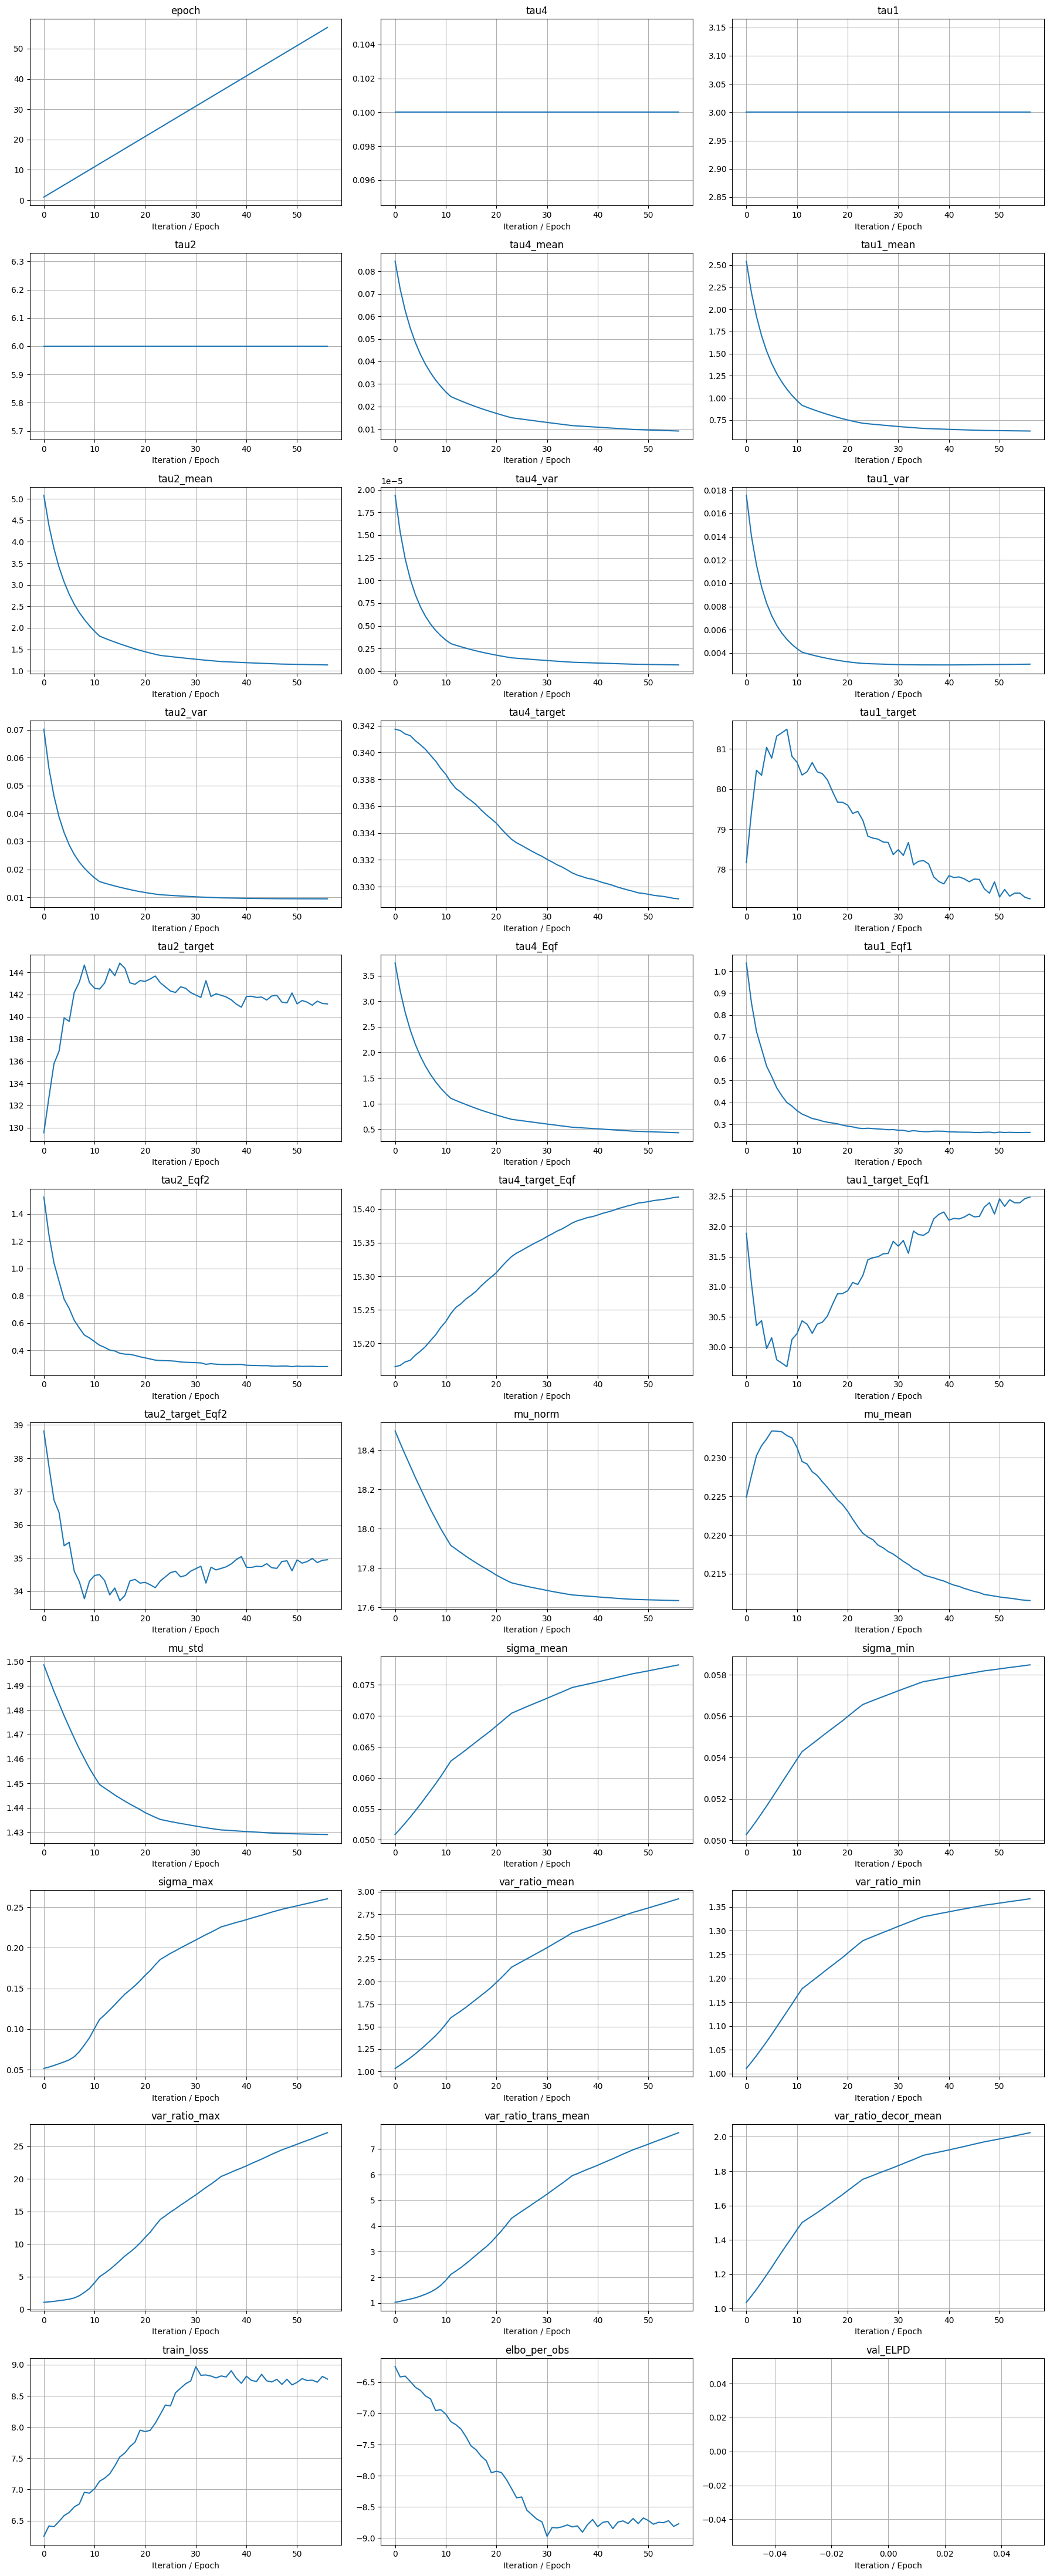

In [11]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



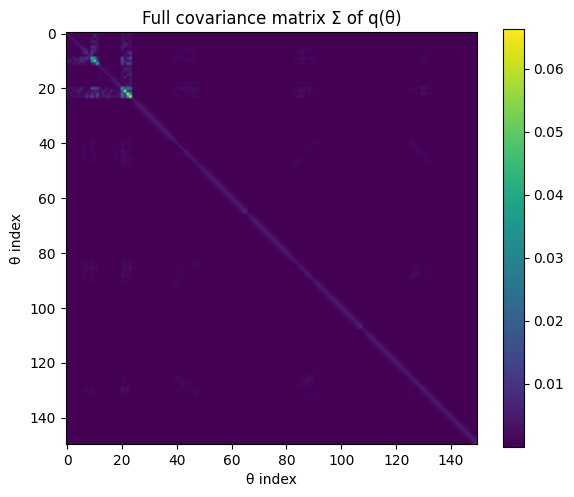

In [13]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


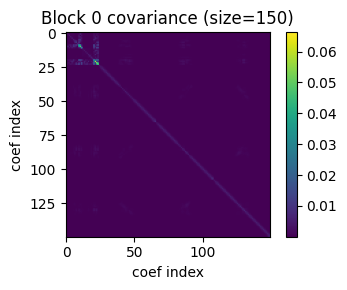

In [14]:
def plot_blocks_covariance(VI):
    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [15]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [17]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0047
KLD GTM      Train Data:  0.0042
KLD Gaussian Train Data:  0.1179
KLD Copula   Train Data:  -0.0013

KLD BGTM      Test  Data:  0.0238
KLD GTM      Test  Data:  0.019
KLD Gaussian Test  Data:  0.11
KLD Copula   Test  Data:  0.0025


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = VI.predictive_sample(
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    n_samples=10_000,
    S=32,
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


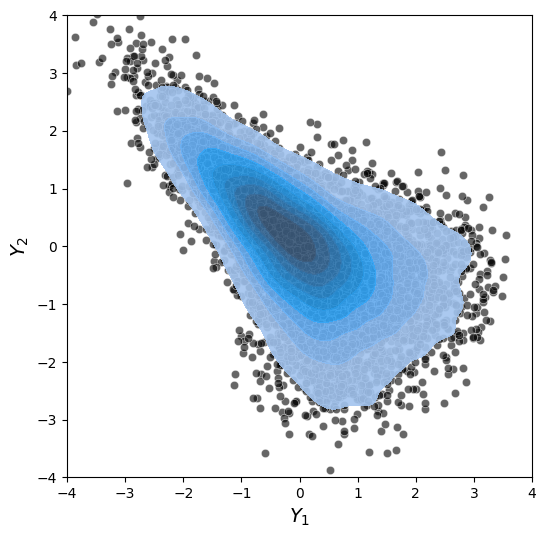

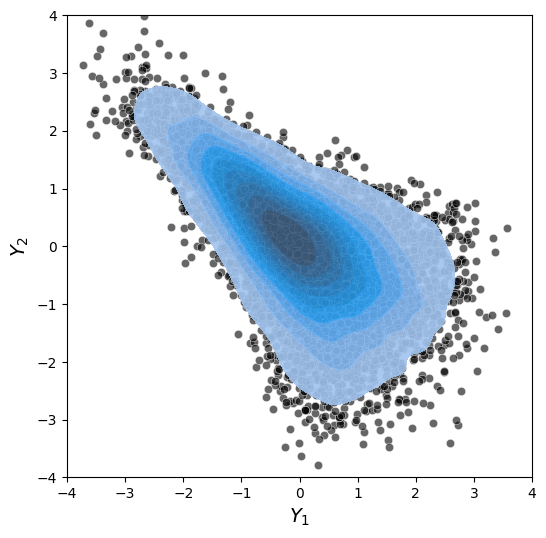

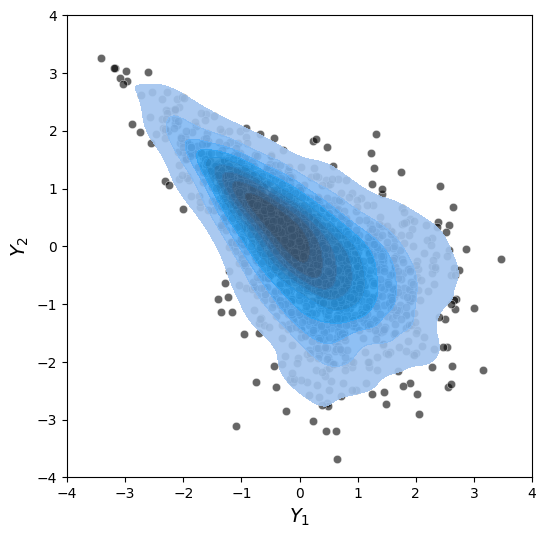

In [19]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


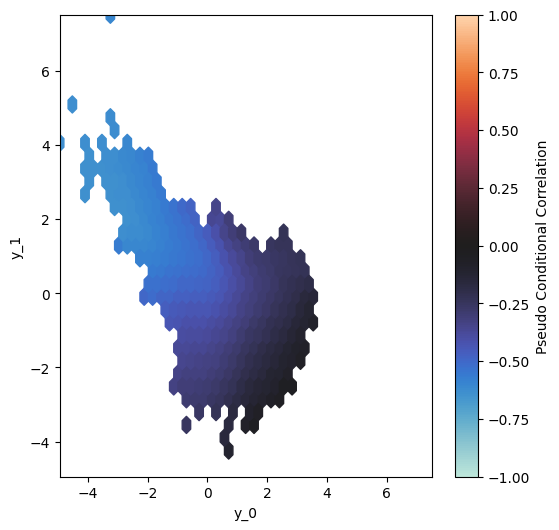

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


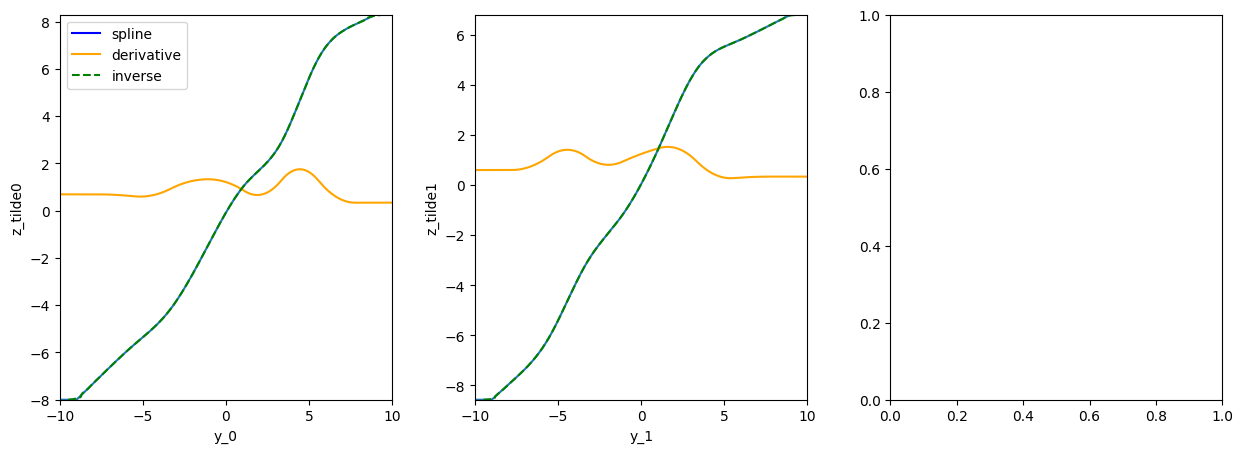

In [22]:
model.plot_splines(layer_type="transformation")

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


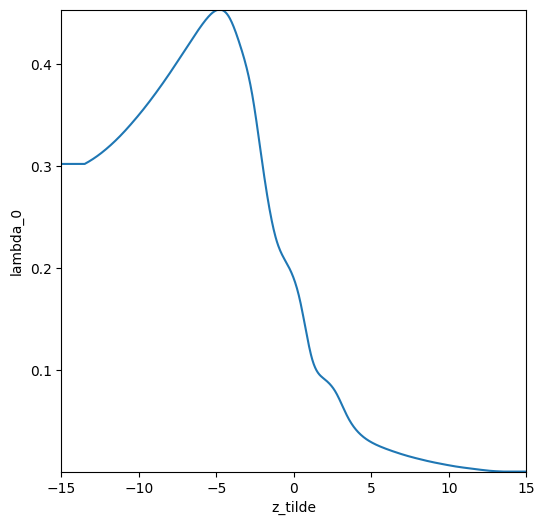

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


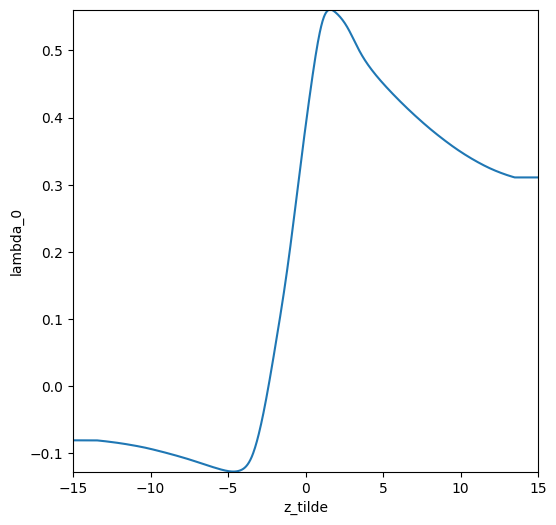

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


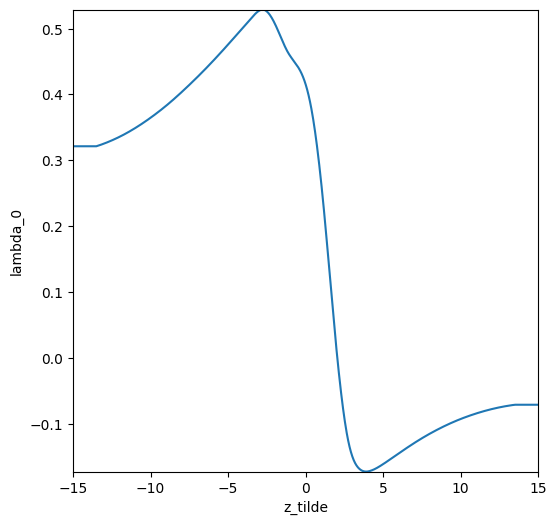

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)